In [392]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.api as sm

# for type hinting
from typing import List

# for pearson corr coef and p values
from scipy.stats import pearsonr

# For plotting relationships
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch, ArrowStyle
from matplotlib.text import Annotation
import seaborn as sns

# for non linear coefficients
from scipy.stats import spearmanr
from scipy.spatial.distance import squareform, pdist
from sklearn.feature_selection import mutual_info_regression

In [2]:
# for cuda core use but not installing......
#import cupy as cp

In [3]:
# Load data from CSV
df = pd.read_csv('D:\GitHub\MSc-Project-March\SWaT DataSWaT 10 sec.csv')


In [4]:
df.head()

,FIT101,LIT101,MV101,P101,P102,AIT201,AIT202,AIT203,FIT201,MV201,...,P502,PIT501,PIT502,PIT503,FIT601,P601,P602,P603,date,time
0,0.0,123.97593,1.0,1.0,1.0,251.9226,8.313061,312.79160,0.0,1.0,...,1.0,9.100231,0.0,3.3485,0.000256,1.0,1.0,1.0,2015-12-22,16:30:00
1,0.0,124.40769,1.0,1.0,1.0,251.9226,8.308960,312.90185,0.0,1.0,...,1.0,9.100231,0.0,3.3485,0.000256,1.0,1.0,1.0,2015-12-22,16:30:10
2,0.0,123.90527,1.0,1.0,1.0,251.9226,8.310979,312.80442,0.0,1.0,...,1.0,9.100231,0.0,3.3485,0.000256,1.0,1.0,1.0,2015-12-22,16:30:20
3,0.0,123.90134,1.0,1.0,1.0,251.9226,8.312612,312.91980,0.0,1.0,...,1.0,9.037747,0.0,3.3485,0.000256,1.0,1.0,1.0,2015-12-22,16:30:30
4,0.0,124.85909,1.0,1.0,1.0,251.9226,8.308191,313.00950,0.0,1.0,...,1.0,9.068188,0.0,3.3485,0.000256,1.0,1.0,1.0,2015-12-22,16:30:40


In [5]:
print(f"Date Range is from {df['date'].min()} to {df['date'].max()}")

Date Range is from 2015-12-22 to 2015-12-28


See range of values in each column so allow filtering of unchanging values before correlation matrix.

In [6]:
# Get columns
#column_names = df.columns
#rint(column_names)

In [7]:
def drop_static_columns(df: pd.DataFrame) -> (pd.DataFrame, List[str]):
    """
    Find columns in the DataFrame where all values are the same (static columns).

    Parameters:
        df (DataFrame): All values from SWaT .

    Returns:
        df (DataFrame): Columns from SWaT which have more than 1 value.

    Example:
        df = pd.DataFrame({'LIT101': [1.111, 2.222, 3.333], 'P101': [1, 1, 0], 'P102': [1, 1, 1]})
        static_cols = get_static_columns(df, ['A', 'B', 'C'])
        # static_cols will be ['P102'] since all values are 1.
    """
    column_names = df.columns
    static_columns = []
    for column in column_names:
        if df[column].min() == df[column].max():
            static_columns.append(column)

    df_cleaned = df.drop(columns= static_columns)
    return df_cleaned, static_columns


In [8]:
df_cleaned, dropped_columns = drop_static_columns(df)
print(dropped_columns)
# drop time and date
df_cleaned = df_cleaned.drop(columns= ['date', 'time'])
print(df_cleaned.columns)

['P102', 'P201', 'P202', 'P204', 'P206', 'P401', 'P403', 'P404', 'P502', 'P601', 'P603']
Index(['FIT101', 'LIT101', 'MV101', 'P101', 'AIT201', 'AIT202', 'AIT203',
       'FIT201', 'MV201', 'P203', 'P205', 'DPIT301', 'FIT301', 'LIT301',
       'MV301', 'MV302', 'MV303', 'MV304', 'P301', 'P302', 'AIT401', 'AIT402',
       'FIT401', 'LIT401', 'P402', 'UV401', 'AIT501', 'AIT502', 'AIT503',
       'AIT504', 'FIT501', 'FIT502', 'FIT503', 'FIT504', 'P501', 'PIT501',
       'PIT502', 'PIT503', 'FIT601', 'P602'],
      dtype='object')


Styler might be worth it for formatting tables

In [9]:
#help(Styler)

In [10]:
# Display correlation matrix and p-values
#print("Correlation Matrix:")
#display(correlation_matrix_styled)
#print("\nP-values:")
#display(p_values_styled)

Use a class to hold knowledge about each component which can be updated throughout pipeline. Can include functions which return top antecendent/ dependent modules etc.

In [538]:
# class to act as knowledge object for each component in the system
class Component:
    def __init__(self, name, list_position, correlation_dict= None, p_value_dict= None, non_lin_correlation_dict= None, non_lin_p_value_dict = None ):
        self.name = name
        # position in results list
        self.list_position = list_position

        # empty dict for results from EDA for components relationship to all other components
        self.correlation_dict = correlation_dict if correlation_dict is not None else {}
        self.p_value_dict = p_value_dict if p_value_dict is not None else {}
        self.non_lin_correlation_dict = non_lin_correlation_dict if non_lin_correlation_dict is not None else {}
        self.non_lin_p_value_dict = non_lin_p_value_dict if p_value_dict is not None else {}

    def get_correlated_components(self, source_data= 'linear', lower_threshold= 0, upper_threshold= 1):
        """
        Returns correlations, takes optional min threshold argument (default is 1 for all values).

        Parameters:
        - threshold: The minimum correlation value.

        Returns:
        - A dictionary containing component names as keys and correlation values as values.
        """
        correlated_components = {}
        if source_data == 'linear':
            for component, correlation in self.correlation_dict.items():
                if component != self.name and  lower_threshold <= abs(correlation) <= upper_threshold:
                    correlated_components[component] = correlation
            return correlated_components

        if source_data == 'non_linear':
            correlated_components = {}
            for component, correlation in self.non_lin_correlation_dict.items():
                if component != self.name and  lower_threshold <= abs(correlation) <= upper_threshold:
                    correlated_components[component] = correlation
            return correlated_components

    def get_correlated_components_p_value(self, source_data= 'linear', lower_threshold= 0, upper_threshold= 0.05):
        """
        Returns correlated components by p-value, takes optional max threshold argument (default is 1 for all values).

        Parameters:
        - threshold: The minimum correlation value.

        Returns:
        - A dictionary containing component names as keys and p values as values.
        """
        correlated_components_p_value = {}

        if source_data == 'linear':
            for component, p_value in self.p_value_dict.items():
                if component != self.name and  lower_threshold <= p_value <= upper_threshold:
                    correlated_components_p_value[component] = p_value
            return correlated_components_p_value

        if source_data == 'non_linear':
            for component, p_value in self.non_lin_p_value_dict.items():
                if component != self.name and  lower_threshold <= p_value <= upper_threshold:
                    correlated_components_p_value[component] = p_value
            return correlated_components_p_value


    def plot_network(self, source_data= 'correlation_matrix',lower_threshold= 0.5, upper_threshold= 1, layout= nx.spring_layout ):
        """
        Plot a network of components linked by correlation strength above a certain threshold.
        """
        # Create a graph
        G = nx.Graph()

        if source_data == 'correlation_matrix':
            # Add nodes (components) and edges ( correlation)
            for component, correlation in self.get_correlated_components('linear', lower_threshold,upper_threshold).items():
                G.add_node(component, correlation_strength=correlation)
                G.add_edge(self.name, component, weight= correlation)
            # Set title
            plt.title(f"Network of Components Linked by Correlation Strength (upper_threshold: {upper_threshold}, lower_threshold: {lower_threshold})")

        elif source_data == 'correlation_p_value':
            # Add nodes (components) and edges ( correlation)
            for component, p_value in self.get_correlated_components_p_value('linear', lower_threshold, upper_threshold).items():
                G.add_node(component, correlation_strength= p_value)
                G.add_edge(self.name, component, weight= p_value)

            # Set title
            plt.title(f"Network of Components Linked by P Value (upper_threshold: {upper_threshold}, lower_threshold: {lower_threshold})")

        if source_data == 'non_lin_correlation':
            # Add nodes (components) and edges ( correlation)
            for component, correlation in self.get_correlated_components('non_linear', lower_threshold,upper_threshold).items():
                G.add_node(component, correlation_strength=correlation)
                G.add_edge(self.name, component, weight= correlation)
            # Set title
            plt.title(f"Network of Components Linked by Non Linear Correlation Strength (upper_threshold: {upper_threshold}, lower_threshold: {lower_threshold})")

        elif source_data == 'non_lin_correlation_p_value':
            # Add nodes (components) and edges ( correlation)
            for component, p_value in self.get_correlated_components_p_value('non_linear', lower_threshold,upper_threshold).items():
                G.add_node(component, correlation_strength= p_value)
                G.add_edge(self.name, component, weight= p_value)
            # Set title
            plt.title(f"Network of Components Linked by Non Linear P Value (upper_threshold: {upper_threshold}, lower_threshold: {lower_threshold})")



        # Draw the graph
        pos = layout(G)  # Use layout argument if passed
        nx.draw(G, pos, with_labels=True, node_size=500, node_color='skyblue', font_size=10, font_weight='bold')
        edge_labels = nx.get_edge_attributes(G, 'weight')
        nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

        # Show the plot
        plt.show()


    def plot_comparison_network(self, lower_threshold=0.5, upper_threshold=1, layout=nx.spring_layout):
        """
        Plot a network of components linked by correlation strength above a certain threshold,
        showing an edge if either linear or non-linear correlation is above the minimum threshold,
        and differentiating between correlations with curved edges. Labels are offset to reduce overlap.
        """
        G = nx.MultiDiGraph()

        # Add nodes and edges for linear correlation
        for component, correlation in self.correlation_dict.items():
            if lower_threshold <= abs(correlation) <= upper_threshold or abs(self.non_lin_correlation_dict.get(component, 0)) > lower_threshold:
                G.add_node(component, correlation_strength=correlation)
                G.add_edge(self.name, component, weight=correlation, correlation_type='Linear')

        # Add nodes and edges for non-linear correlation
        for component, correlation in self.non_lin_correlation_dict.items():
            if lower_threshold <= abs(correlation) <= upper_threshold or abs(self.correlation_dict.get(component, 0)) > lower_threshold:
                G.add_node(component, correlation_strength=correlation)
                G.add_edge(self.name, component, weight=correlation, correlation_type='Non-linear')

        plt.figure(figsize=(10, 10))
        pos = layout(G)

        # Draw nodes and labels
        nx.draw_networkx_nodes(G, pos, node_size=700, node_color="skyblue", alpha=0.6)
        nx.draw_networkx_labels(G, pos, font_weight="bold")

        # Function to draw edges with FancyArrowPatch and labels with offset
        def draw_edges_with_arrows_and_labels():
            for (u, v, attribs) in G.edges(data=True):
                edge_type = attribs['correlation_type']
                weight = attribs['weight']
                color = 'red' if edge_type == 'Non-linear' else 'blue'
                style = 'dashed' if edge_type == 'Non-linear' else 'solid'
                rad = 0.1 if edge_type == 'Non-linear' else -0.1

                arrow = FancyArrowPatch(pos[u], pos[v], arrowstyle='-|>', color=color,
                                        linestyle=style, connectionstyle=f'arc3,rad={rad}', linewidth=2, alpha=0.5)
                plt.gca().add_patch(arrow)

                # Calculate label position with offset
                label_x = (pos[u][0] + pos[v][0]) / 2
                label_y = (pos[u][1] + pos[v][1]) / 2 + (0.1 if edge_type == 'Non-linear' else -0.1)

                plt.text(label_x, label_y, f'{weight:.2f}', color='black', fontsize=10,
                         ha='center', va='center', bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'))

        draw_edges_with_arrows_and_labels()

        plt.axis('off')
        plt.title("Network of Components Linked by Correlation Strength")
        plt.show()






In [539]:
# iterate through every column and create object of component class
# dictionary for all components
components = {}
for n, component in enumerate(df_cleaned.columns):
    # print(n, component)
    components[component] = Component(name= component, list_position= n)


### Calculate the linear (Pearson) correlation matrix

In [540]:
# Calculate the linear correlation matrix
correlation_matrix = df_cleaned.corr().round(decimals= 4)

# DataFrame to store p-values with rows and cols being column names
p_values = pd.DataFrame(index=df_cleaned.columns, columns=df_cleaned.columns)

# Calculate p-values
# for every column
for col1 in df_cleaned.columns:
    # calculate values with everyother column
    for col2 in df_cleaned.columns:
        correlation_coefficient, p_value = pearsonr(df_cleaned[col1], df_cleaned[col2])
        # Save values to corresponding location in p_values df, rounded to 4.d.p
        p_values.loc[col1, col2] = round(p_value, 4)

# Apply a color gradient to the correlation matrix and display it
correlation_matrix_styled  = correlation_matrix.style.background_gradient(cmap='coolwarm').format(precision= 2)
p_values_styled  = p_values.style.background_gradient(cmap='coolwarm').format(precision= 2)



In [541]:
#index_values = correlation_matrix.index.values
#print(index_values)

In [542]:
specific_component = components['LIT101']
#specific_component.correlation_list
#specific_component.correlation_dict

In [543]:
#specific_component.get_correlated_components(0.2,1)

### Calculate the correlation matrix using Spearman's rank correlation

In [544]:
# Calculate the correlation matrix using Spearman's rank correlation
non_lin_correlation_matrix = df_cleaned.corr(method='spearman').round(decimals=4)

# DataFrame to store p-values with rows and cols being column names
non_lin_p_values = pd.DataFrame(index=df_cleaned.columns, columns=df_cleaned.columns)

# Calculate p-values
# for every column
for col1 in df_cleaned.columns:
    # calculate values with every other column
    for col2 in df_cleaned.columns:
        correlation_coefficient, p_value = spearmanr(df_cleaned[col1], df_cleaned[col2])
        # Save values to corresponding location in p_values df, rounded to 4.d.p
        non_lin_p_values.loc[col1, col2] = round(p_value, 4)

# Apply a color gradient to the correlation matrix and display it
non_lin_correlation_matrix_styled = non_lin_correlation_matrix.style.background_gradient(cmap='coolwarm').format(precision=2)
non_lin_p_values_styled = non_lin_p_values.style.background_gradient(cmap='coolwarm').format(precision=2)


## Mutual Information is slow.........

# Calculate mutual information between features
mutual_info_matrix = pd.DataFrame(index=df_cleaned.columns, columns=df_cleaned.columns)

# Calculate mutual information
for col1 in df_cleaned.columns:
    for col2 in df_cleaned.columns:
        mutual_info = mutual_info_regression(df_cleaned[[col1]], df_cleaned[col2])[0]
        mutual_info_matrix.loc[col1, col2] = mutual_info

# Display the mutual information matrix
print(mutual_info_matrix)


In [545]:
# Display the mutual information matrix
# print(mutual_info_matrix)

## Linear and Non Linear Corr Matrices

Get

In [546]:
# Assuming components is a dictionary with component names as keys and Component objects as values
for component_name, component_obj in components.items():
    # Convert correlation coefficient row to dictionary with row index and value
    correlation_dict = {col: value for col, value in zip(correlation_matrix.columns, correlation_matrix.loc[component_name])}
    component_obj.correlation_dict = correlation_dict
    print(component_name, component_obj.correlation_dict )

    # Convert p-value row to dictionary with row index and value
    p_value_dict = {col: value for col, value in zip(p_values.columns, p_values.loc[component_name])}
    #p_value_dict = {index: value for index, value in enumerate(p_values.loc[component_name])}
    component_obj.p_value_dict = p_value_dict

FIT101 {'FIT101': 1.0, 'LIT101': -0.6478, 'MV101': 0.9805, 'P101': 0.2205, 'AIT201': -0.0021, 'AIT202': -0.0864, 'AIT203': 0.032, 'FIT201': 0.2267, 'MV201': 0.2223, 'P203': 0.2287, 'P205': 0.1672, 'DPIT301': -0.202, 'FIT301': -0.2092, 'LIT301': 0.3514, 'MV301': 0.0364, 'MV302': -0.1873, 'MV303': 0.0768, 'MV304': 0.0108, 'P301': 0.0371, 'P302': -0.2233, 'AIT401': -0.0275, 'AIT402': 0.0685, 'FIT401': 0.0251, 'LIT401': 0.4062, 'P402': 0.0177, 'UV401': 0.0177, 'AIT501': -0.0245, 'AIT502': 0.0716, 'AIT503': 0.1096, 'AIT504': -0.0109, 'FIT501': 0.0253, 'FIT502': 0.0269, 'FIT503': 0.0155, 'FIT504': 0.0048, 'P501': 0.0155, 'PIT501': 0.0266, 'PIT502': 0.0542, 'PIT503': 0.0284, 'FIT601': 0.0589, 'P602': 0.0565}
LIT101 {'FIT101': -0.6478, 'LIT101': 1.0, 'MV101': -0.6527, 'P101': -0.6587, 'AIT201': 0.0044, 'AIT202': 0.2195, 'AIT203': -0.138, 'FIT201': -0.6668, 'MV201': -0.6591, 'P203': -0.6671, 'P205': -0.4893, 'DPIT301': -0.1531, 'FIT301': -0.1511, 'LIT301': 0.1817, 'MV301': -0.0416, 'MV302': -0.

In [547]:
# Assuming components is a dictionary with component names as keys and Component objects as values
for component_name, component_obj in components.items():
    # Convert correlation coefficient row to dictionary with row index and value
    non_lin_correlation_dict = {col: value for col, value in zip(non_lin_correlation_matrix.columns, non_lin_correlation_matrix.loc[component_name])}
    component_obj.non_lin_correlation_dict = non_lin_correlation_dict
    print(component_name, component_obj.non_lin_correlation_dict )

    # Convert p-value row to dictionary with row index and value
    non_lin_p_value_dict = {col: value for col, value in zip(non_lin_p_values.columns, non_lin_p_values.loc[component_name])}
    #p_value_dict = {index: value for index, value in enumerate(p_values.loc[component_name])}
    component_obj.non_lin_p_value_dict = non_lin_p_value_dict

FIT101 {'FIT101': 1.0, 'LIT101': -0.488, 'MV101': 0.774, 'P101': 0.1751, 'AIT201': -0.0131, 'AIT202': -0.1574, 'AIT203': 0.0006, 'FIT201': -0.0134, 'MV201': 0.1766, 'P203': 0.1814, 'P205': 0.1311, 'DPIT301': -0.1721, 'FIT301': -0.1026, 'LIT301': 0.3733, 'MV301': 0.0123, 'MV302': -0.1468, 'MV303': 0.0457, 'MV304': 0.0117, 'P301': 0.0322, 'P302': -0.1728, 'AIT401': -0.0096, 'AIT402': 0.0603, 'FIT401': 0.0479, 'LIT401': 0.4899, 'P402': 0.0122, 'UV401': 0.0124, 'AIT501': -0.005, 'AIT502': 0.0758, 'AIT503': 0.1009, 'AIT504': 0.0213, 'FIT501': 0.0485, 'FIT502': 0.0314, 'FIT503': 0.0003, 'FIT504': -0.0653, 'P501': 0.0104, 'PIT501': 0.0362, 'PIT502': 0.0719, 'PIT503': 0.0383, 'FIT601': -0.0048, 'P602': 0.0467}
LIT101 {'FIT101': -0.488, 'LIT101': 1.0, 'MV101': -0.6239, 'P101': -0.641, 'AIT201': -0.0061, 'AIT202': 0.5272, 'AIT203': -0.3624, 'FIT201': -0.389, 'MV201': -0.6422, 'P203': -0.6471, 'P205': -0.4798, 'DPIT301': -0.127, 'FIT301': -0.0678, 'LIT301': 0.1962, 'MV301': -0.0255, 'MV302': -0.1

# Visualising Relationships

In [548]:
df_cleaned.shape

(49500, 40)

In [549]:
#specific_component.get_correlated_components('linear',0.01, 1)

In [550]:
len(specific_component.get_correlated_components('linear', 0.01, 1))

38

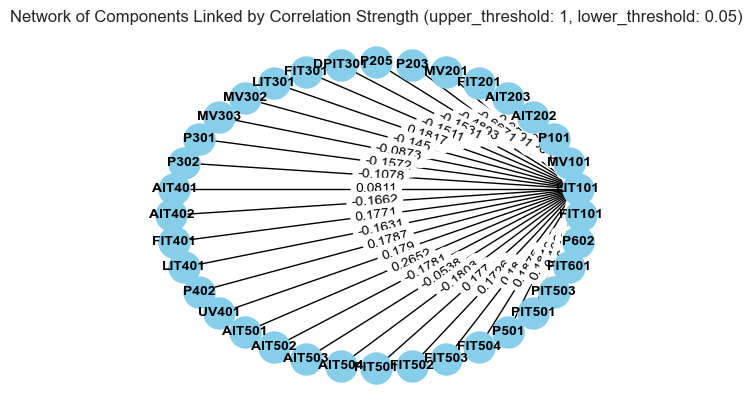

In [551]:
specific_component.plot_network('correlation_matrix', 0.05, 1, nx.circular_layout )

In [552]:
len(specific_component.get_correlated_components('linear', 0.6, 1))

6

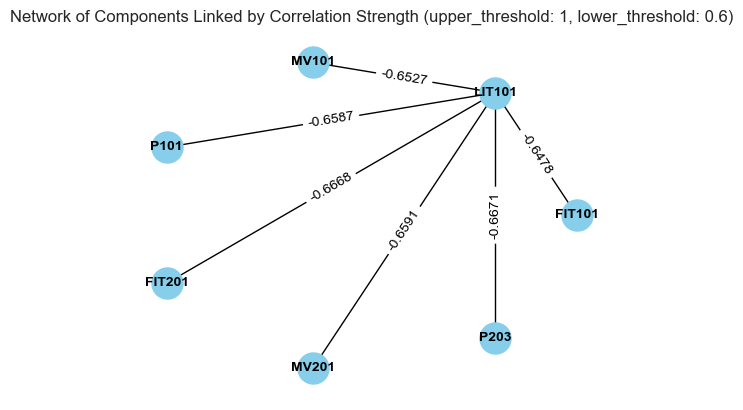

In [553]:
specific_component.plot_network('correlation_matrix', 0.6, 1, nx.circular_layout )

In [554]:
specific_component.get_correlated_components_p_value('linear', 0.0, 0.05)

{'FIT101': 0.0,
 'MV101': 0.0,
 'P101': 0.0,
 'AIT202': 0.0,
 'AIT203': 0.0,
 'FIT201': 0.0,
 'MV201': 0.0,
 'P203': 0.0,
 'P205': 0.0,
 'DPIT301': 0.0,
 'FIT301': 0.0,
 'LIT301': 0.0,
 'MV301': 0.0,
 'MV302': 0.0,
 'MV303': 0.0,
 'MV304': 0.0037,
 'P301': 0.0,
 'P302': 0.0,
 'AIT401': 0.0,
 'AIT402': 0.0,
 'FIT401': 0.0,
 'LIT401': 0.0,
 'P402': 0.0,
 'UV401': 0.0,
 'AIT501': 0.0,
 'AIT502': 0.0,
 'AIT503': 0.0,
 'AIT504': 0.0,
 'FIT501': 0.0,
 'FIT502': 0.0,
 'FIT503': 0.0,
 'FIT504': 0.0,
 'P501': 0.0,
 'PIT501': 0.0,
 'PIT502': 0.0,
 'PIT503': 0.0,
 'FIT601': 0.0,
 'P602': 0.0}

In [555]:
 len(specific_component.get_correlated_components_p_value('linear', 0.0, 0.05))

38

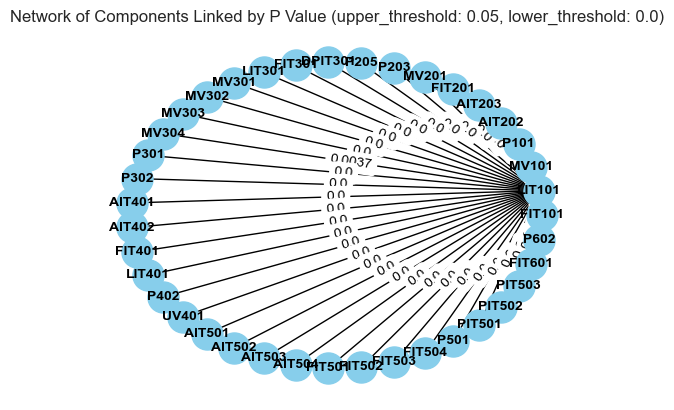

In [556]:
specific_component.plot_network('correlation_p_value', 0.0, 0.05, nx.circular_layout )

## Observations
P value ( statistical significance) value of 5% indicates 38 of 39 components disprove the null hypothesis that the relationship between components is random. This numebr of related components is acheived by using a Pearson correlation coefficient 0f 0.01 or above ( a very week linear correlation).
These Values were calculated from the correlation from the LIT101 water level sensor which is the main water tank at the beginning of the process ( and so is understandably linked to all other components to some degree.
Restricted the results to correlation coefficients above 0.6 identifies 5 componnets with strong correlations, all of which are in the same or following stage and are related to the movement of water ( pumps or flow sensors). This suggests the Pearson values are more useful is revelaing system dependencies.


# Non-Linear Correlation of Components
The previous stage looked for linear correlation between components, other non- linear methods were evaluated as the complex interplay of componets could lead to non-linear behaviour even with pairwise linear relationships. These methods look for monatonic relationships- the values for two components consistently change together ( positive or negative).

In [557]:
# Display correlation matrix and p-values
#print("non_lin Correlation Matrix:")
#display(non_lin_correlation_matrix_styled)


In [558]:
#non_lin_p_values_styled

In [559]:
specific_component.get_correlated_components('non_linear', 0.6, 1)

{'MV101': -0.6239, 'P101': -0.641, 'MV201': -0.6422, 'P203': -0.6471}

In [560]:
len(specific_component.get_correlated_components('non_linear', 0.6, 1))

4

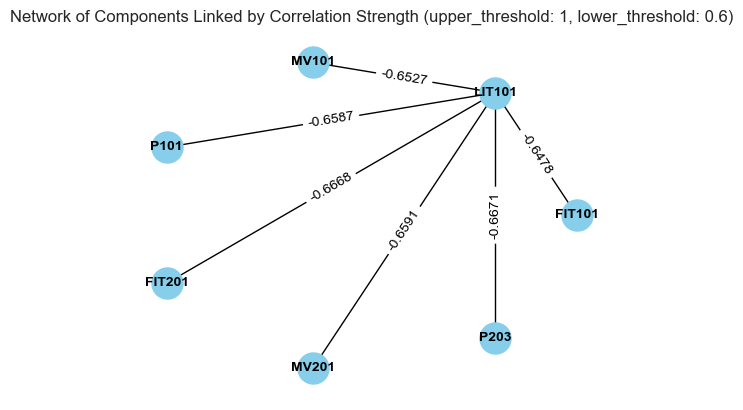

In [561]:
specific_component.plot_network('correlation_matrix', 0.6, 1, nx.circular_layout )

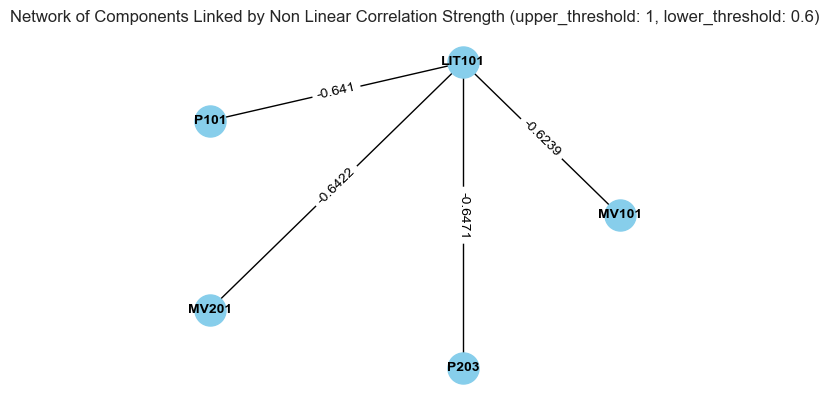

In [562]:
specific_component.plot_network('non_lin_correlation', 0.6, 1, nx.circular_layout )

In [563]:
# Add type of correlation to each matrix
correlation_matrix['Correlation Type'] = 'Pearson'
non_lin_correlation_matrix['Correlation Type'] = 'Spearman'

# jsut use spearman for now
#mutual_info_matrix['Correlation Type'] = 'Mutal_Info'

In [564]:
# Concatenate two correlation matrices vertically
#merged_correlation_matrix = pd.concat([correlation_matrix, non_lin_correlation_matrix, mutual_info_matrix])
#merged_correlation_matrix = pd.concat([correlation_matrix, non_lin_correlation_matrix])
# Display the merged correlation matrix
#print(merged_correlation_matrix)

In [565]:
# Get rows for the component named "LIT101" from the merged correlation matrix
rows_for_LIT101 = correlation_matrix.loc["LIT101"]

# Display the rows for LIT101
print(rows_for_LIT101.head())

FIT101   -0.6478
LIT101       1.0
MV101    -0.6527
P101     -0.6587
AIT201    0.0044
Name: LIT101, dtype: object


In [566]:
specific_component.correlation_dict

{'FIT101': -0.6478,
 'LIT101': 1.0,
 'MV101': -0.6527,
 'P101': -0.6587,
 'AIT201': 0.0044,
 'AIT202': 0.2195,
 'AIT203': -0.138,
 'FIT201': -0.6668,
 'MV201': -0.6591,
 'P203': -0.6671,
 'P205': -0.4893,
 'DPIT301': -0.1531,
 'FIT301': -0.1511,
 'LIT301': 0.1817,
 'MV301': -0.0416,
 'MV302': -0.145,
 'MV303': -0.0873,
 'MV304': -0.0131,
 'P301': -0.1572,
 'P302': -0.1078,
 'AIT401': 0.0811,
 'AIT402': -0.1662,
 'FIT401': 0.1771,
 'LIT401': -0.1631,
 'P402': 0.1787,
 'UV401': 0.179,
 'AIT501': 0.2652,
 'AIT502': -0.1781,
 'AIT503': -0.0538,
 'AIT504': -0.1803,
 'FIT501': 0.177,
 'FIT502': 0.1726,
 'FIT503': 0.18,
 'FIT504': 0.1875,
 'P501': 0.1818,
 'PIT501': 0.166,
 'PIT502': -0.0271,
 'PIT503': 0.162,
 'FIT601': -0.0676,
 'P602': -0.0648}

In [567]:
specific_component.non_lin_correlation_dict

{'FIT101': -0.488,
 'LIT101': 1.0,
 'MV101': -0.6239,
 'P101': -0.641,
 'AIT201': -0.0061,
 'AIT202': 0.5272,
 'AIT203': -0.3624,
 'FIT201': -0.389,
 'MV201': -0.6422,
 'P203': -0.6471,
 'P205': -0.4798,
 'DPIT301': -0.127,
 'FIT301': -0.0678,
 'LIT301': 0.1962,
 'MV301': -0.0255,
 'MV302': -0.1913,
 'MV303': -0.0958,
 'MV304': -0.0431,
 'P301': -0.1039,
 'P302': -0.1747,
 'AIT401': 0.0019,
 'AIT402': -0.1206,
 'FIT401': 0.0257,
 'LIT401': -0.3085,
 'P402': 0.0939,
 'UV401': 0.0942,
 'AIT501': 0.0753,
 'AIT502': -0.1471,
 'AIT503': -0.0059,
 'AIT504': 0.0333,
 'FIT501': 0.0256,
 'FIT502': 0.0261,
 'FIT503': -0.0241,
 'FIT504': 0.012,
 'P501': 0.0965,
 'PIT501': -0.0423,
 'PIT502': -0.0622,
 'PIT503': -0.0426,
 'FIT601': -0.0517,
 'P602': -0.099}

In [568]:
correlation_matrix.head()

,FIT101,LIT101,MV101,P101,AIT201,AIT202,AIT203,FIT201,MV201,P203,...,FIT502,FIT503,FIT504,P501,PIT501,PIT502,PIT503,FIT601,P602,Correlation Type
FIT101,1.0000,-0.6478,0.9805,0.2205,-0.0021,-0.0864,0.0320,0.2267,0.2223,0.2287,...,0.0269,0.0155,0.0048,0.0155,0.0266,0.0542,0.0284,0.0589,0.0565,Pearson
LIT101,-0.6478,1.0000,-0.6527,-0.6587,0.0044,0.2195,-0.1380,-0.6668,-0.6591,-0.6671,...,0.1726,0.1800,0.1875,0.1818,0.1660,-0.0271,0.1620,-0.0676,-0.0648,Pearson
MV101,0.9805,-0.6527,1.0000,0.2337,-0.0020,-0.0899,0.0338,0.2399,0.2356,0.2419,...,0.0263,0.0152,0.0044,0.0152,0.0264,0.0537,0.0282,0.0593,0.0569,Pearson
P101,0.2205,-0.6587,0.2337,1.0000,0.0016,-0.3130,0.1253,0.9949,0.9940,0.9956,...,0.0484,0.0404,0.0340,0.0410,0.0452,0.0508,0.0454,0.0492,0.0494,Pearson
AIT201,-0.0021,0.0044,-0.0020,0.0016,1.0000,-0.1015,-0.3301,0.0026,-0.0013,0.0010,...,0.1223,0.0583,0.0597,0.0837,0.0383,-0.1904,0.0234,-0.0000,0.0003,Pearson


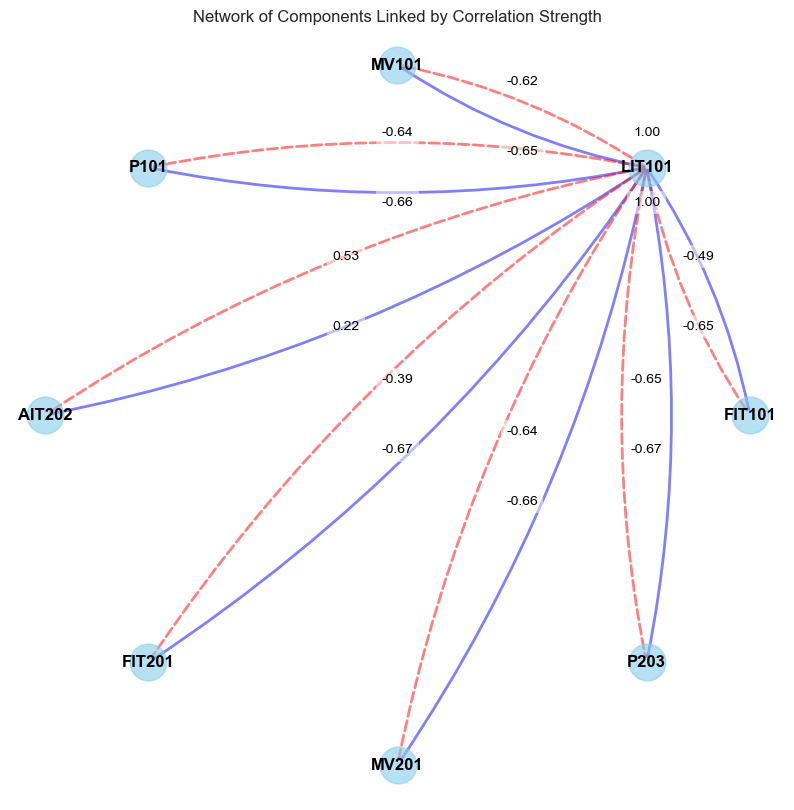

In [569]:
specific_component.plot_comparison_network(.5, 1, nx.circular_layout )

In [533]:
type(specific_component)

__main__.Component

In [534]:
display(rows_for_LIT101)

FIT101              -0.6478
LIT101                  1.0
MV101               -0.6527
P101                -0.6587
AIT201               0.0044
AIT202               0.2195
AIT203               -0.138
FIT201              -0.6668
MV201               -0.6591
P203                -0.6671
P205                -0.4893
DPIT301             -0.1531
FIT301              -0.1511
LIT301               0.1817
MV301               -0.0416
MV302                -0.145
MV303               -0.0873
MV304               -0.0131
P301                -0.1572
P302                -0.1078
AIT401               0.0811
AIT402              -0.1662
FIT401               0.1771
LIT401              -0.1631
P402                 0.1787
UV401                 0.179
AIT501               0.2652
AIT502              -0.1781
AIT503              -0.0538
AIT504              -0.1803
FIT501                0.177
FIT502               0.1726
FIT503                 0.18
FIT504               0.1875
P501                 0.1818
PIT501              

In [535]:
# Create masks for Spearman and Mutual Information correlations higher than Pearson
spearman_higher_mask = non_lin_correlation_matrix > correlation_matrix
mutual_info_higher_mask = mutual_info_matrix > correlation_matrix

# Extract values where Spearman correlation is higher than Pearson
spearman_higher_values = non_lin_correlation_matrix[spearman_higher_mask]

# Extract values where Mutual Information correlation is higher than Pearson
mutual_info_higher_values = mutual_info_matrix[mutual_info_higher_mask]

# Combine the extracted values
higher_values = pd.concat([spearman_higher_values, mutual_info_higher_values])

# Plot the higher values
plt.figure(figsize=(10, 6))
sns.barplot(x=higher_values.index, y=higher_values.values, palette='coolwarm')
plt.title('Values where Spearman or Mutual Info are higher than Pearson')
plt.xlabel('Component Pair')
plt.ylabel('Correlation Value')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


NameError: name 'mutual_info_matrix' is not defined

# Original Section

Get distributions for each variable. Get range, divide into 100 bins then count variables ineach. Visualise in plot

In [ ]:
# make new df to hold variable distributions
df_distributions = pd.DataFrame()

Sample df as 10 second mean for all values so df is 10% of original to east manipulation

In [ ]:
def plotBinCounts(name, bin_counts, bin_edges):
    '''
    Function to plot the distribution of bin counts.
    Parameters:
    - bin_counts: a pandas Series containing the counts of values in each bin.
    - bin_edges: an array containing the bin edges.
    '''

    # Set the size of the plot
    plt.figure(figsize=(10,6))

    # Plot the bin counts
    bin_counts.plot(kind='bar', logy=True)

    # Set the title and labels
    plt.title(f'Distribution of {name}')
    plt.ylabel('Counts')

    # Calculate total range and step size for approximately 10 divisions
    total_range = bin_edges[-1] - bin_edges[0]
    step_size = total_range / 10

    # Round step size to a whole number (e.g., 10, 20, etc.) that makes sense for your data
    rounded_step_size = round(step_size / 10) * 10

    # Generate custom tick positions and labels
    tick_positions = np.arange(0, len(bin_edges) - 1, rounded_step_size / (bin_edges[1] - bin_edges[0]))
    tick_labels = [f"{bin_edges[int(pos)]:.0f}" for pos in tick_positions]

    # Set x-ticks to represent the overall value range of the bins
    plt.xticks(ticks=tick_positions,
               labels=tick_labels,
               rotation=45)  # Rotate labels for better readability

    # Optional: Set x-axis label
    plt.xlabel('Value Range')

    # Show the plot
    plt.show()

# Example usage:
# Assuming bin_counts and bins are obtained from the getDistribution function
# plotBinCounts(bin_counts, bins)


In [ ]:
# function to get distribution
def getDistribution(variable_col):
    '''
    Function to get distribution of values in variable column.
    Returns
    '''
    #get variable min and max values and calculate range

    var_range = df[variable_col].max() - df[variable_col].min()

    print(f'Var Range:  {var_range}')

    # divide into 100 bins
    bin_size = var_range/100

    # Create bins edges from min to max with using bin_size'
    bins = np.arange(df[variable_col].min(), df[variable_col].max() + bin_size, bin_size)

    # Use pd.cut to segment and sort the data values into bins
    df_distributions[variable_col + '_bins'] = pd.cut(df[variable_col], bins=bins, include_lowest=True)

    # Count the number of values in each bin
    bin_counts = df_distributions[variable_col + '_bins'].value_counts().sort_index()

    # call sisualisation function
    plotBinCounts(variable_col, bin_counts, bins)

    # return bin_counts, bins

In [184]:
# test with FIT101
#lit101_dist, bins = getDistribution('LIT101')
#plotBinCounts(lit101_dist, bins)

getDistribution('LIT101')

Var Range:  696.22615


NameError: name 'df_distributions' is not defined

1,FIT-101,Sensor,Flow meter; Measures inflow into raw water tank.
2,LIT-101,Sensor,Level Transmitter; Raw water tank level.
3,MV-101,Actuator,Motorized valve; Controls water flow to the raw water tank.

In [ ]:
getDistribution('MV101')

In [ ]:
getDistribution('FIT101')

In [ ]:
getDistribution('P101')